In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import os

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [8]:
train_images.shape

(60000, 28, 28)

In [10]:
train_labels.shape

(60000,)

In [11]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

## Pre-processing

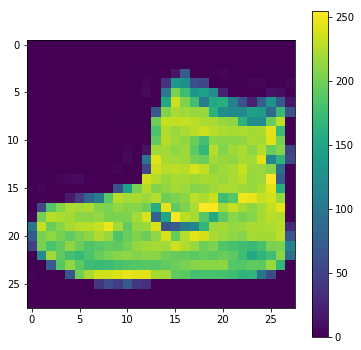

In [17]:
# We can see that the pixel values fall in the range of 0 to 255.
plt.figure(figsize=(6,6))
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

In [18]:
# Scaling these values to a range of 0 to 1.

train_images = train_images / 255.0
test_images = test_images / 255.0

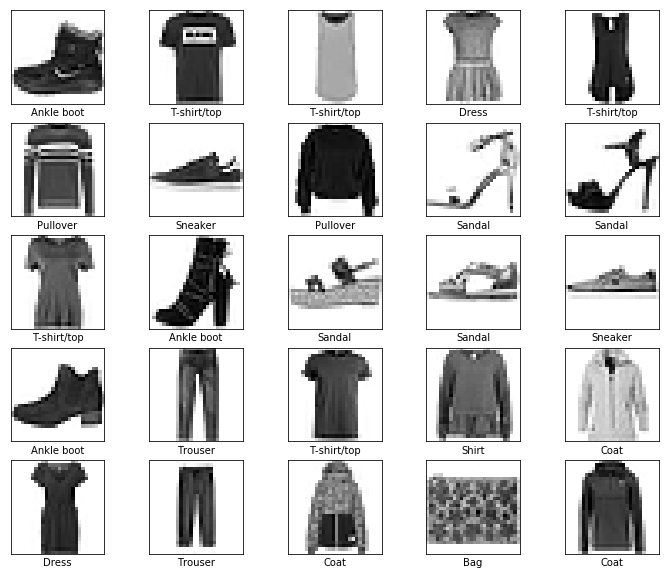

In [27]:
# plotting first 25 images

plt.figure(figsize=(12,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [42]:
m = train_images.shape[0]

In [64]:
# Flatten the training images from 2d array to 1d array
train_images_flattened = train_images.flatten().reshape(m, 784)
test_images_flattened = test_images.flatten().reshape(test_images.shape[0], 784)

In [66]:
# Creating Validation set
X_valid, X_train = train_images_flattened[:5000], train_images_flattened[5000:]
y_valid, y_train = train_labels[:5000], train_labels[5000:]

## Construction phase

In [72]:
n_inputs = 784
hidden1 = 300
hidden2 = 150
n_outputs = 10

In [73]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None,n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

In [74]:
# Building deep neural net

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, hidden1, activation=tf.nn.relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, hidden2, activation=tf.nn.relu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, name='logits')

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [75]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    loss_summary = tf.summary.scalar('log_loss', loss)

In [76]:
learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

In [77]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [78]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [79]:
# Directory to write tensorboard logs

from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs_fashion-mnist"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}".format(root_logdir, name)

In [80]:
logdir = log_dir("fashion_mnist")

In [81]:
# FileWriter to write TensorBoard logs
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [82]:
def shuffle_batch(X, y, batch_size):
    rnn_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnn_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [84]:
# Implementing early stopping.

m, n = X_train.shape

n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_fashion_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_fashion_mnist_final_model.ckpt"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("Training was interrupted, continuing at epoch ", start_epoch)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, 
                                                                                  loss_summary], feed_dict={X: X_valid, y:y_valid})
        
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        
        if epoch % 5 == 0:
            print("Epoch: ", epoch,
                  "\tValidation Accuracy: {:.3f}%".format(accuracy_val * 100),
                  "\tLoss: {:.5f}%".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, 'wb') as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early Stopping")
                    break

Epoch:  0 	Validation Accuracy: 82.840% 	Loss: 0.54029%
Epoch:  5 	Validation Accuracy: 86.140% 	Loss: 0.39485%
Epoch:  10 	Validation Accuracy: 87.540% 	Loss: 0.35305%
Epoch:  15 	Validation Accuracy: 87.900% 	Loss: 0.33767%
Epoch:  20 	Validation Accuracy: 88.820% 	Loss: 0.32004%
Epoch:  25 	Validation Accuracy: 88.740% 	Loss: 0.31195%
Epoch:  30 	Validation Accuracy: 89.060% 	Loss: 0.30694%
Epoch:  35 	Validation Accuracy: 89.560% 	Loss: 0.29792%
Epoch:  40 	Validation Accuracy: 89.340% 	Loss: 0.29503%
Epoch:  45 	Validation Accuracy: 89.680% 	Loss: 0.28848%
Epoch:  50 	Validation Accuracy: 89.380% 	Loss: 0.30086%
Epoch:  55 	Validation Accuracy: 88.600% 	Loss: 0.31629%
Epoch:  60 	Validation Accuracy: 89.760% 	Loss: 0.29664%
Epoch:  65 	Validation Accuracy: 89.980% 	Loss: 0.28666%
Epoch:  70 	Validation Accuracy: 89.860% 	Loss: 0.28444%
Epoch:  75 	Validation Accuracy: 89.580% 	Loss: 0.31044%
Epoch:  80 	Validation Accuracy: 89.880% 	Loss: 0.29677%
Epoch:  85 	Validation Accuracy: 

In [85]:
os.remove(checkpoint_epoch_path)

In [87]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    accuracy_val = accuracy.eval(feed_dict={X: test_images_flattened, y: test_labels})

INFO:tensorflow:Restoring parameters from ./my_fashion_mnist_final_model.ckpt


In [88]:
accuracy_val

0.8881